# Variational Fashion Encoder

In this experiment I want to try out [Variational Auto Encoders](https://arxiv.org/pdf/1606.05908.pdf)
on a new fashion classification dataset from [Zalando](https://github.com/zalandoresearch/fashion-mnist).

First copy the /data/fashion/ folder from the zalando repository next to this notebook.

I will build a generic Variational Auto Encoder and then learn it on the new fashion-mnist dataset.

In [38]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

from scipy.misc import imsave
from scipy.misc import imresize

In [64]:
labels_dict = {
    0: "T-shirt-top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

In [39]:
data = input_data.read_data_sets('data/fashion/')

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [31]:
n_samples = data.train.num_examples
np.random.seed(0)
tf.set_random_seed(0)

# Variational Auto Encoder

![VAE](images/vae_small.png)

+ The bottom part of the model is embedding the input X into a mean and variance vector
+ The mean and variance represent the parameters of a gaussian that is trained to be close to a standard normal distribution N(0, I)
+ The decoder network is trying to reconstruct the input from a sample from said distribution
+ Implementation is inspired by hwalsuklee [github](https://github.com/hwalsuklee/tensorflow-mnist-VAE/blob/master/vae.py)

First lets define some standard utils to make construction of the neural network easier. We define an
initialization method called Xavier that samples uniformly: 
$$(-\sqrt{\frac{6}{in + out}}, \sqrt{\frac{6}{in + out}})$$
We then define a layer by the weights(Xavier) and biases(zeros) and it's result as:
$$z = x * W +b$$

In [10]:
def xavier(nin, nout):
    hi = np.sqrt( 6 / (nin + nout))
    lo = -hi
    w  = tf.random_uniform((nin, nout), minval=lo, maxval=hi, dtype= tf.float32)
    return w

def bias(nout):
    return tf.zeros([nout], dtype=tf.float32)

def layer(x, l, nin, nout):
    w = tf.Variable(xavier(nin, nout), name="W" + str(l))    
    b = tf.Variable(bias(nout), name= "b" + str(l))
    z = tf.matmul(x, w) + b
    return z

In the encoder part the input is fed through feed forward layers multiple layers. In this case I chose to
use ReLu activations except for the output. The output layer is special since it's activation is used
as the parameters of a multivariate normal disribution with a diagonal covariance matrix or in other words a variance vector.The mean vector and the variance vector are concatenated.
$$output = [\mu, \sigma]$$
That means that the encoders output needs to be twice as large.
Furthermore, the output's activation is a tanh function. A ReLu function's
output is between 0 and 1 but a normal distribution has real valued parameters.
A tanh gives values between -1 and 1 which is more appropriate.

In [11]:
def encoder(x, shapes):         
    a = x
    l = 0
    for nin, nout in shapes:
        if l == len(shapes) - 1:
            z = layer(a, l, nin, nout * 2) # In the last layer, the embedding represents the mean and variance concat
            a = tf.nn.tanh(z)
        else:            
            z = layer(a,l, nin, nout)
            a = tf.nn.relu(z)
        l += 1
    n_out = int(int(a.shape[1]) / 2)       
    mean = a[:, n_out:]
    sigm = 1e-6 + tf.nn.softplus(a[:, :n_out])
    return (mean, sigm)

The decoder network is a simple feed forward net with ReLu activations and
a sigmoid output

In [12]:
def decoder(x, shapes):         
    a = x
    l = 0
    for nin, nout in shapes:     
        z = layer(a, l, nin, nout)
        if l == 0:
            a = tf.nn.tanh(z)
        elif l == len(shapes) - 1:
            a = tf.nn.sigmoid(z)
        else:            
            a = tf.nn.relu(z)
        l += 1
    return a

The actual variation autoencder then passes the input through the encoder
receiving the mean and variance of the normal distribution. 
A sample is drawn from said distribution and passed into the decoder.

The loss for the decoder is defined using the difference between the input and the output.
The encoder loss uses the kullback leibler divergence to a standard normal.
The ELBO is the expectaion lower bound.

In [13]:
def vae(x, enc_shapes, dec_shapes):
    mu, sigm = encoder(x, enc_shapes)
    sample = mu + sigm * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)
    y = decoder(sample, dec_shapes)
    
    marginal_likelihood = tf.reduce_sum(x * tf.log(y) + (1 - x) * tf.log(1 - y), 1)
    KL_divergence = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigm) - tf.log(1e-8 + tf.square(sigm)) - 1, 1)

    marginal_likelihood = tf.reduce_mean(marginal_likelihood)
    KL_divergence = tf.reduce_mean(KL_divergence)

    ELBO = marginal_likelihood - KL_divergence

    loss = -ELBO
    return y, sample, loss, -marginal_likelihood, KL_divergence

The decoder is basically the encoder reversed. The learning is set up below using the
adam optimizer

In [89]:
def reverse(shapes):
    x = [(o, i) for i, o in shapes]
    x.reverse()
    return x

input_layer = tf.placeholder(tf.float32, shape=(None, 784))
enc_shapes = [
    (784, 512),
    (512, 256),
    (256, 128)
]
dec_shapes = reverse(enc_shapes)

rate = 0.001
batch_size = 100
total_batch = int(n_samples / batch_size)
epochs = 15

y, z, loss, neg_marginal_likelihood, KL_divergence = vae(input_layer, enc_shapes, dec_shapes)
train_op = tf.train.AdamOptimizer(rate).minimize(loss)

Last but not least learning the model using batch gradient descent and then plotting the reconstruction

Learning: 
   - epoch:  0 161702.415771 153777.431686 7924.98451328
   - epoch:  1 149525.335297 140822.032837 8703.30261803
   - epoch:  2 146101.445404 137494.988144 8606.45704937
   - epoch:  3 143942.39444 135611.789566 8330.60508823
   - epoch:  4 142381.743637 134188.057465 8193.68599033
   - epoch:  5 141037.465149 133022.697372 8014.76774311
   - epoch:  6 140191.615234 132252.400162 7939.21492767
   - epoch:  7 139565.244125 131649.623154 7915.62095547
   - epoch:  8 138908.577972 131001.05162 7907.52618885
   - epoch:  9 138475.038956 130601.710159 7873.32890701
   - epoch:  10 137877.390564 130022.25882 7855.13171482
   - epoch:  11 137736.757767 129911.039566 7825.71821594
   - epoch:  12 137292.604843 129420.437119 7872.16791153
   - epoch:  13 137201.322021 129313.063614 7888.25850964
   - epoch:  14 137067.918335 129166.511078 7901.40739155
Reconstruction: 
 - reconstructing: Sneaker 0 0 0
 - reconstructing: Dress 1 0 1
 - reconstructing: Pullover 2 0 2
 - reconstructing

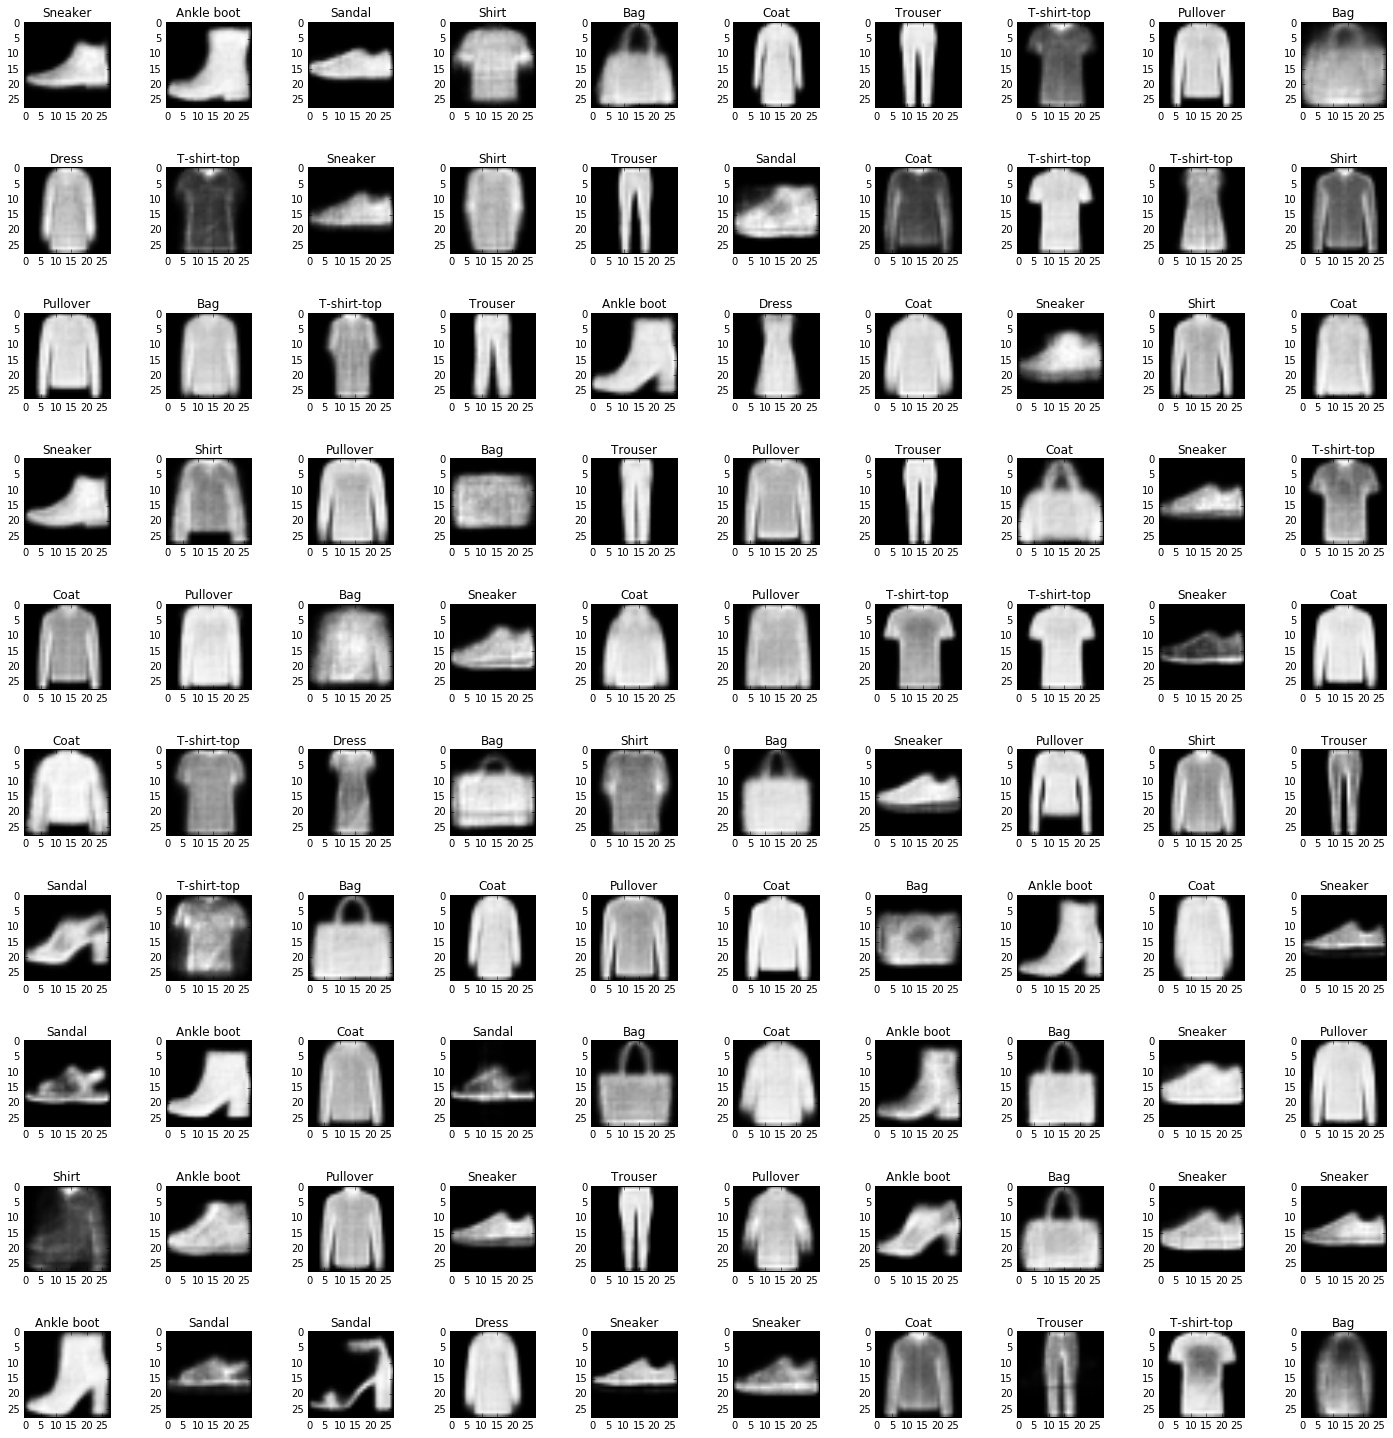

In [90]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("Learning: ")
    for epoch in range(epochs):
        total_loss = 0.0
        loss_lik   = 0.0
        loss_div   = 0.0
        for i in range(0, total_batch):
            (batch, _) = data.train.next_batch(batch_size)
            _, tot_loss, loss_likelihood, loss_divergence = sess.run(
                (train_op, loss, neg_marginal_likelihood, KL_divergence),
                feed_dict={ input_layer: batch }
            )
            total_loss += tot_loss
            loss_lik   += loss_likelihood
            loss_div   += loss_divergence
        print("   - epoch: ", epoch, total_loss, loss_lik, loss_div)

    print("Reconstruction: ")
    (images, labels) = data.test.next_batch(100)
    f, axarr = plt.subplots(10, 10)

    a = 0
    b = 0
    for i in range(0, 100):
        if a == 10:
            a = 0
            b += 1
        
        y_out = sess.run(y, feed_dict={input_layer: images[i].reshape(1, 784)})
        y_img = y_out.reshape(28, 28)
        print(" - reconstructing: " + labels_dict[labels[i]], a, b, i)
        axarr[a, b].set_title(labels_dict[labels[i]])
        axarr[a, b].imshow(y_img, cmap=plt.get_cmap('gray'))  
        a += 1
    
    f.subplots_adjust(hspace = 0.7)
    f.set_size_inches(25.0, 25.0, forward=True)
    plt.savefig("result/prediction.png")        
print("Done")